# Imports

In [17]:
import sys
import os

# Dynamically add the root directory to sys.path
# Assumes that 'models' and 'utils' are in the same project root directory
project_root = os.path.abspath(os.path.join(os.path.dirname('.'), '..'))
sys.path.insert(0, project_root)


In [246]:
# sklearn
from sklearn.metrics import accuracy_score

# torch
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# torch eeg library
from torcheeg import transforms
from torch.utils.data import DataLoader
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from torcheeg.datasets import DREAMERDataset
from torcheeg.model_selection import KFoldGroupbyTrial
from torcheeg.model_selection import train_test_split_groupby_trial

# Other
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Local Imports
from utils.checkpoint import train_and_save
from utils.log import get_logger
from utils.utils import print_var, train_one_epoch, train_one_epoch_lstm, get_num_params, train_one_step_tqdm
from models.cnn import Two_Layer_CNN, Two_Layer_CNN_Pro, Simplified_CNN
from models.rnns import LSTM

In [ ]:
# nice label transform
label_transform=transforms.Compose([
    transforms.Select(['valence', 'arousal']),
    transforms.Binary(5.0),
    transforms.BinariesToCategory()])

# Read Data

## load data

In [73]:
dataset_name = 'Dreamer_time_series_01'
emotion_dim = 'valence'  # valence, dominance, or arousal

mat_path = '../raw_data/DREAMER.mat'  # path to the DREAMER.mat file
io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset

# Import data
dataset = DREAMERDataset(io_path=f"{io_path}",
                        mat_path=mat_path,
                        offline_transform=transforms.Compose([
                            transforms.MeanStdNormalize(),#MeanStdNormalize() , MinMaxNormalize()
                        ]),
                        online_transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]),
                        label_transform=transforms.Compose([
                            transforms.Select(emotion_dim),
                            transforms.Binary(threshold=2.5),
                             
                        ]),
                        chunk_size=128,
                        baseline_chunk_size=128,
                        num_baseline=61,
                        num_worker=4)



[2024-11-25 15:23:53] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../saves/datasets/Dreamer_time_series_01.


In [ ]:
# To 2D for tsception

dataset_name = 'Dreamer_2D_1'
emotion_dim = 'valence'  # valence, dominance, or arousal

mat_path = '../raw_data/DREAMER.mat'  # path to the DREAMER.mat file
io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset

dataset = DREAMERDataset(io_path=f"{io_path}",
                         mat_path=mat_path,
                         offline_transform=transforms.Compose([
                             transforms.BaselineRemoval(),
                             transforms.MeanStdNormalize(),
                             transforms.To2d()
                         ]),
                         online_transform=transforms.ToTensor(),
                         label_transform=transforms.Compose([
                             transforms.Select('valence'),
                             transforms.Binary(3.0)
                         ]),
                         chunk_size=128,
                         baseline_chunk_size=128,
                         num_baseline=61,
                         num_worker=4)

[2024-11-25 18:27:54] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to ../saves/datasets/Dreamer_2D_1.
[2024-11-25 18:27:54] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]:  17%|█▋        | 4/23 [00:00<00:00, 24.58it/s]
[RECORD 0]: 0it [00:00, ?it/s]
[RECORD 0]: 1it [00:07,  7.99s/it]
[RECORD 0]: 4it [00:08,  1.55s/it]
[RECORD 0]: 6it [00:08,  1.11it/s]
[RECORD 0]: 8it [00:08,  1.74it/s]
[RECORD 0]: 10it [00:08,  2.44it/s]
[RECORD 0]: 12it [00:08,  3.39it/s]
[RECORD 0]: 14it [00:08,  4.59it/s]
[RECORD 0]: 16it [00:08,  6.02it/s]
[RECORD 0]: 18it [00:09,  6.69it/s]
[RECORD 0]: 20it [00:09,  8.24it/s]
[RECORD 0]: 23it [00:09, 10.75it/s]
[RECORD 0]: 25it [00:09, 10.30it/s]
[RECORD 0]: 27it [00:09,  8.82it/s]
[RECORD 0]: 29it [00:10,  8.32it/s]
[RECORD 0]: 31it [00:10,  8.20it/s]
[RECORD 0]: 32it [00:10,  7.82

In [74]:
dataset[0][0].shape

torch.Size([14, 128])

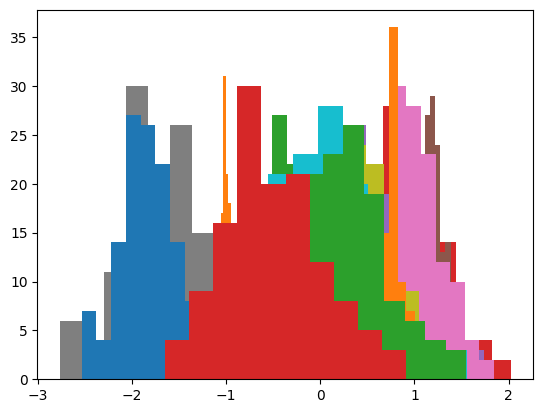

In [76]:
for i in range(14):
    plt.hist(dataset[100][0][i,:])


## Split data

In [77]:
rng_num = 122
train_dataset, test_dataset = train_test_split_groupby_trial(dataset= dataset, test_size = 0.2, shuffle= True, random_state= rng_num)
train_dataset, val_dataset = train_test_split_groupby_trial(dataset= train_dataset, test_size = 0.2, shuffle=True, random_state= rng_num)

[2024-11-25 15:35:53] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2024-11-25 15:35:53] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1732536353956_4d92q for the next run, if you want to use the same setting for the experiment.
[2024-11-25 15:35:55] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2024-11-25 15:35:55] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1732536355138_5lBx6 for the next run, if you want to use the same setting for the experiment.
[PROCESS]:  30%|███       | 7/23 [22:22:42<51:09:03, 11508.99s/it]


In [80]:
len(train_dataset),len(val_dataset) , len(test_dataset), len(dataset)

(54533, 13869, 17342, 85744)

## create dataloader

In [81]:
train_loader = DataLoader(train_dataset, batch_size= 256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= 256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= 256, shuffle=False)

# Define model

In [162]:
next(iter(train_loader))[0].shape

torch.Size([256, 14, 128])

In [283]:
class LSTM_CNN_Model(nn.Module):
    def __init__(self,in_channel=14, hidden_size1=64, hidden_size2= 128, hidden_size_lstm= 256, num_layers= 1, num_classes=1, dropout_prob=0.5):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout_prob)
        self.af = nn.ReLU()
        
        # CNN
        self.conv1 = nn.Conv1d(in_channels= in_channel, out_channels=hidden_size1 , kernel_size= 3 ,padding=1)
        self.bn1 = nn.BatchNorm1d(num_features= hidden_size1)
        self.max_pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels= hidden_size1, out_channels=hidden_size2 , kernel_size= 3 ,padding=1)
        self.bn2 = nn.BatchNorm1d(num_features= hidden_size2)
        self.max_pool2 = nn.MaxPool1d(4)

        # LSTM
        self.num_layers = num_layers
        self.hidden_size_lstm = hidden_size_lstm
        self.lstm = nn.LSTM(hidden_size2, hidden_size_lstm, num_layers, batch_first=True)


        # fully connected
        self.fc = nn.LazyLinear(num_classes)


    def forward(self, x): # [batch, 14, 128]
        x = self.conv1(x) # [batch, 64, 64]
        x = self.bn1(x)
        x = self.af(x)
        x = self.dropout(x)
        x = self.max_pool1(x) # [batch, 64, 32]

        x = self.max_pool2(self.dropout(self.af(self.bn2(self.conv2(x))))) # [batch, 128, 16] -> F x L

        # lstm section
        x = x.permute(0, 2, 1) # (Batch, Length, features = 128 channels)
        # Initialize hidden state and cell state with random values
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size_lstm).to(x.device)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size_lstm).to(x.device)

        # Forward propagate the LSTM
        out, (_,_) = self.lstm(x, (h0, c0)) #

        # x = self.fc(out[:, -1, :])
        x = self.fc(out.flatten(1))
        x = nn.functional.sigmoid(x)

        return x


2048

# Test model with little data

In [279]:
x, y = next(iter(train_loader))
model = LSTM_CNN_Model()
print(model(x).shape)
print(get_num_params(model,1))

torch.Size([256, 1])
423361.0


In [ ]:
from torcheeg.models import TSCeption
# TSCeption config for DREAMER
model = TSCeption(num_electrodes=14,
                    num_classes=2,
                    num_T=15,
                    num_S=15,
                    in_channels=1,
                    hid_channels=32,
                    sampling_rate=128,
                    dropout=0.5)
model(torch.randn(10,14,128))

RuntimeError: Given groups=1, weight of size [15, 1, 1, 64], expected input[1, 10, 14, 128] to have 1 channels, but got 10 channels instead

# Optimize learning parameters

# Train

In [284]:
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = LSTM_CNN_Model()
model = model.to(device)

num_epochs = 20 # 300
model_name = model.__class__.__name__
print(f"Start training {model_name} for {num_epochs} epoch")

# Lists to store loss and accuracy values
loss_hist = []
acc_hist = []

# Initialize the best loss variable to track the least loss
best_loss = float('inf')  # Set to infinity initially to ensure it gets updated in the first epoch


for epoch in range(num_epochs):
    # Model training (assuming train_one_step_tqdm is implemented)
    model, loss, acc = train_one_step_tqdm(model, train_loader, loss_fn, optimizer, device, epoch, True)
    
    loss_hist.append(loss)
    acc_hist.append(acc)

print("Training process is done!")



Using device: cuda
Start training LSTM_CNN_Model for 20 epoch


Epoch: 0:   0%|          | 0/214 [00:00<?, ?batch/s]

Epoch: 11:  40%|████      | 86/214 [00:05<00:07, 17.19batch/s, accuracy=49.1, loss=0.669]


KeyboardInterrupt: 